# 경로지정
143

In [4]:
import pandas as pd
from pathlib import Path
import shutil  # 파일 복사용

# -------------------------------------------------------
# 경로 설정
# -------------------------------------------------------
CSV_PATH = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/ASAN_01_Repeatition_Counter/data/metadata.csv")

# 확인할 행 번호
TARGET_ROW = 20

# -------------------------------------------------------
# CSV 로드 및 행 접근
# -------------------------------------------------------
meta = pd.read_csv(CSV_PATH)

# -------------------------------------------------------
# 개별 경로 생성
# -------------------------------------------------------
FRAME_DIR = Path(str(meta.loc[TARGET_ROW]['frame_path']))
KEYPOINTS_DIR = Path(str(meta.loc[TARGET_ROW]['keypoints_path']))
INTERP_DIR = Path(str(meta.loc[TARGET_ROW]['interp_json_path']))
VIDEO_DIR =  Path(str(meta.loc[TARGET_ROW]['mp4_path']))

# -------------------------------------------------------
# 존재 여부 확인 및 폴더 생성
# -------------------------------------------------------
for p in [FRAME_DIR, KEYPOINTS_DIR, INTERP_DIR, VIDEO_DIR]:
    if not p.exists():
        if p == INTERP_DIR:
            p.mkdir(parents=True, exist_ok=True)
            print(f"📁 생성 완료: {p}")
        else:
            print(f"❌ 없음: {p}")
    else:
        print(f"✅ 존재: {p}")

    
# -------------------------------------------------------
# 현재 처리 대상 이름 변수 분리
# -------------------------------------------------------
parent_name = FRAME_DIR.parent.name                # 상위 폴더명 (예: N01_Ward)
current_name = FRAME_DIR.name                      # 현재 폴더명 (예: lateral__overhead_triceps_extension)
target_name = f"{parent_name}/{current_name}"      # 결합된 이름 생성

# -------------------------------------------------------
# 정보 출력
# -------------------------------------------------------
print(f"\nis_train = {meta.loc[TARGET_ROW]['is_train']}")       # 학습 데이터 여부 출력
print(f"is_train = {meta.loc[TARGET_ROW]['is_val']}")       # 학습 데이터 여부 출력

print(f"\n🎯 현재 처리 대상: {target_name}")                      # 상위폴더/하위폴더 형태로 출력

✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/1_FRAME/AI_dataset/N01/N01_Treatment/lateral__biceps_curl
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/2_KEYPOINTS/AI_dataset/N01/N01_Treatment/lateral__biceps_curl
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N01/N01_Treatment/lateral__biceps_curl
✅ 존재: /workspace/nas203/ds_RehabilitationMedicineData/IDs/tojihoo/3_project_HCCmove/data/3_MP4/AI_dataset/N01/N01_Treatment/lateral__biceps_curl.mp4

is_train = True
is_train = False

🎯 현재 처리 대상: N01_Treatment/lateral__biceps_curl


# JSON 복사

In [34]:
from tqdm import tqdm
import shutil

# -------------------------------------------------------
# 🔁 keypoints → interp_json 복사 (with tqdm)
# -------------------------------------------------------
if KEYPOINTS_DIR.exists():
    json_files = list(KEYPOINTS_DIR.glob("*.json"))
    for json_file in tqdm(json_files, desc="📦 JSON 복사 중", ncols=80):
        shutil.copy(json_file, INTERP_DIR / json_file.name)  # JSON 복사
    print(f"✅ {len(json_files)}개 JSON 복사 완료 → {INTERP_DIR}")
else:
    print("⚠️ KEYPOINTS_DIR가 존재하지 않아 복사 스킵됨")


📦 JSON 복사 중: 100%|███████████████████████| 345/345 [00:00<00:00, 441.35it/s]

✅ 345개 JSON 복사 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__pec_dec_fly


# 필수 함수

## frame overlay 시각화 함수

In [4]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (1) Frame overlay 시각화 함수 (2열 배치, 5~16만 표시)
# -------------------------------------------------------
def visualize_frame_overlay(frame_dir: Path, json_dir: Path, frame_idx: int, window: int = 5):
    """
    frame_idx 기준 ±window 프레임의 skeleton을 시각화 (2열 다중행)
    - COCO 17 중 5~16만 표시
    """
    start_idx = max(0, frame_idx - window)
    end_idx = frame_idx + window + 1
    frame_indices = list(range(start_idx, end_idx))
    n_frames = len(frame_indices)

    # COCO 17개 중 5~16만 남기기
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # -------------------------------------------------------
    # Subplot 설정 (2열 자동 행 계산)
    # -------------------------------------------------------
    n_cols = 2
    n_rows = int(np.ceil(n_frames / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))
    axes = np.array(axes).reshape(-1)  # 1D로 평탄화

    for ax, idx in zip(axes, frame_indices):
        frame_path = frame_dir / f"{idx:06d}.jpg"
        json_path = json_dir / f"{idx:06d}.json"

        if not frame_path.exists() or not json_path.exists():
            ax.axis("off")
            continue

        frame = cv2.imread(str(frame_path))
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            ax.axis("off")
            continue

        for person in data["instance_info"]:
            kpts = np.array(person["keypoints"])
            for a, b in links:
                if a >= len(kpts) or b >= len(kpts):
                    continue
                pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
                cv2.line(frame, pt1, pt2, (80, 80, 80), 2)

            for kp_idx, (x, y) in enumerate(kpts):
                if kp_idx < 5 or kp_idx > 16:
                    continue
                if kp_idx in left_points:
                    color = (255, 0, 0)
                elif kp_idx in right_points:
                    color = (0, 0, 255)
                else:
                    color = (0, 255, 0)
                cv2.circle(frame, (int(x), int(y)), 4, color, -1)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {idx:06d}", fontsize=10)
        ax.axis("off")

    # 남는 subplot 숨김
    for ax in axes[n_frames:]:
        ax.axis("off")

    plt.suptitle(f"Skeletons around Frame {frame_idx:06d} (±{window})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [5]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------------------
# (2) 단일 프레임 skeleton 시각화 함수
# -------------------------------------------------------
def visualize_single_frame(frame_dir: Path, json_dir: Path, frame_idx: int, show_kp_idx: bool = True):
    """
    지정한 단일 프레임을 크게 시각화 (5~16 keypoints만 표시)
    - show_kp_idx=True → 각 keypoint 번호도 함께 출력
    """
    frame_path = frame_dir / f"{frame_idx:06d}.jpg"
    json_path = json_dir / f"{frame_idx:06d}.json"

    if not frame_path.exists() or not json_path.exists():
        print(f"❌ Frame {frame_idx:06d}: frame 또는 JSON 없음")
        return

    # ---------------------------------------------------
    # 기본 skeleton 구조 (5~16만)
    # ---------------------------------------------------
    links = [
        (15, 13), (13, 11),
        (16, 14), (14, 12),
        (11, 12),
        (5, 11), (6, 12),
        (5, 6),
        (5, 7), (7, 9),
        (6, 8), (8, 10)
    ]
    left_points = [5, 7, 9, 11, 13, 15]
    right_points = [6, 8, 10, 12, 14, 16]

    # ---------------------------------------------------
    # 데이터 로드
    # ---------------------------------------------------
    frame = cv2.imread(str(frame_path))
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if "instance_info" not in data or not data["instance_info"]:
        print(f"⚠️ Frame {frame_idx:06d}: instance_info 없음")
        return

    # ---------------------------------------------------
    # skeleton overlay
    # ---------------------------------------------------
    for person in data["instance_info"]:
        kpts = np.array(person["keypoints"])
        for a, b in links:
            if a >= len(kpts) or b >= len(kpts):
                continue
            pt1, pt2 = tuple(map(int, kpts[a])), tuple(map(int, kpts[b]))
            cv2.line(frame, pt1, pt2, (80, 80, 80), 3)

        for kp_idx, (x, y) in enumerate(kpts):
            if kp_idx < 5 or kp_idx > 16:
                continue
            if kp_idx in left_points:
                color = (255, 0, 0)
            elif kp_idx in right_points:
                color = (0, 0, 255)
            else:
                color = (0, 255, 0)
            cv2.circle(frame, (int(x), int(y)), 6, color, -1)

            if show_kp_idx:
                cv2.putText(frame, str(kp_idx), (int(x)+5, int(y)-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # ---------------------------------------------------
    # 시각화
    # ---------------------------------------------------
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title(f"Frame {frame_idx:06d}", fontsize=16)
    plt.show()


## 영상 생성 함수

In [6]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video

## IQR 시각화 함수

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# -------------------------------------------------------
# (함수) keypoints 전체 IQR + Boxplot 4컬럼 시각화 (Outlier 표시 포함)
# -------------------------------------------------------
def plot_keypoint_iqr_overview(json_dir: Path, keypoint_range=(5, 17), whisker: float = 1.5):
    """
    keypoint별 X/Y 좌표 시계열 + Boxplot을 한 행에 표시하며,
    IQR 기반 이상치(Outlier)를 점으로 표시.

    Args:
        json_dir (Path): keypoints JSON 폴더
        keypoint_range (tuple): 분석할 keypoints 범위 (기본 5~16)
        whisker (float): IQR 배수 (1.5 → 일반적인 Tukey 기준)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    for jfile in tqdm(json_files):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return q1, q3, iqr, lower, upper

    # -------------------------------------------------------
    # 시각화 준비
    # -------------------------------------------------------
    kp_indices = list(range(*keypoint_range))
    n_kp = len(kp_indices)
    fig, axes = plt.subplots(n_kp, 4, figsize=(18, 2.8 * n_kp))

    if n_kp == 1:
        axes = axes.reshape(1, 4)

    for row_idx, kp_idx in enumerate(kp_indices):
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5:
            continue

        # IQR 계산
        q1x, q3x, iqrx, lower_x, upper_x = compute_iqr(valid_x, whisker)
        q1y, q3y, iqry, lower_y, upper_y = compute_iqr(valid_y, whisker)

        # 이상치 마스크
        outlier_x_mask = (xs < lower_x) | (xs > upper_x)
        outlier_y_mask = (ys < lower_y) | (ys > upper_y)

        # ------------------------------
        # (1) X 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 0]
        ax.plot(frames, xs, color="dodgerblue", linewidth=1)
        ax.axhline(lower_x, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_x, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_x_mask], xs[outlier_x_mask],
                   color="crimson", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} X", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (2) Y 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 1]
        ax.plot(frames, ys, color="darkorange", linewidth=1)
        ax.axhline(lower_y, color="red", linestyle="--", alpha=0.5)
        ax.axhline(upper_y, color="red", linestyle="--", alpha=0.5)
        ax.scatter(frames[outlier_y_mask], ys[outlier_y_mask],
                   color="purple", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} Y", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (3) X Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 2]
        ax.boxplot(xs[~np.isnan(xs)],
                patch_artist=True,
                whis=whisker,                     # ✅ 여기 추가!
                boxprops=dict(facecolor="lightblue", color="navy"),
                medianprops=dict(color="red"),
                flierprops=dict(marker='o', markerfacecolor='crimson',
                                markersize=4, linestyle='none'))

        ax.set_title("X Box", fontsize=9)
        ax.set_xticks([])

        # ------------------------------
        # (4) Y Boxplot (Outlier 자동 표시)
        # ------------------------------
        ax = axes[row_idx, 3]
        ax.boxplot(ys[~np.isnan(ys)],
                patch_artist=True,
                whis=whisker,                     # ✅ 동일하게 반영
                boxprops=dict(facecolor="lightcoral", color="maroon"),
                medianprops=dict(color="black"),
                flierprops=dict(marker='o', markerfacecolor='purple',
                                markersize=4, linestyle='none'))

        ax.set_title("Y Box", fontsize=9)
        ax.set_xticks([])

    plt.suptitle(f"IQR Overview per Keypoint (whisker={whisker})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [8]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) IQR 기반 Outlier 선형보간 (연속 구간 + X/Y 선택)
# -------------------------------------------------------
def interpolate_outliers(json_dir: Path,
                         target_kps=[14, 16],
                         whisker=1.5,
                         axis='both',
                         save_dir: Path = None):
    """
    지정된 keypoints에서 IQR 기반 이상치를 선형 보간으로 수정
    (연속 outlier 구간도 자연스럽게 처리)
    
    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 보간 대상 keypoint index
        whisker (float): IQR 배수
        axis (str): 'x', 'y', 'both' 중 선택
        save_dir (Path): 결과 저장 경로 (None → 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ 전체 keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"], dtype=float)
        if kpts.ndim != 2 or kpts.shape[1] != 2:
            kpts = np.full((17, 2), np.nan)
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ IQR 계산 함수
    # -------------------------------------------------------
    def compute_iqr(values, whisker):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower = q1 - whisker * iqr
        upper = q3 + whisker * iqr
        return lower, upper

    # -------------------------------------------------------
    # 3️⃣ 연속 outlier 구간을 묶어서 보간
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # NaN 제거 후 IQR 계산
        valid_x = xs[~np.isnan(xs)]
        valid_y = ys[~np.isnan(ys)]
        if len(valid_x) < 5 or len(valid_y) < 5:
            print(f"[WARN] kpt{kp_idx}: 데이터 부족 → skip")
            continue

        # 선택된 축에 따라 outlier 계산
        lower_x, upper_x = compute_iqr(valid_x, whisker)
        lower_y, upper_y = compute_iqr(valid_y, whisker)

        outlier_mask_x = (xs < lower_x) | (xs > upper_x)
        outlier_mask_y = (ys < lower_y) | (ys > upper_y)

        if axis == 'x':
            outlier_mask = outlier_mask_x
        elif axis == 'y':
            outlier_mask = outlier_mask_y
        else:  # both
            outlier_mask = outlier_mask_x | outlier_mask_y

        outlier_indices = np.where(outlier_mask)[0]

        if len(outlier_indices) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_indices)}개 Outlier → {axis}-축 기준 연속 구간 보간 중...")

        # 연속 구간 묶기
        groups = []
        current = [outlier_indices[0]]
        for f in outlier_indices[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 각 그룹별 보간 수행
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1
            
            # 1️⃣ frame0부터 시작하는 이상치 구간 처리 (left < 0)
            if left < 0:
                # 다음 정상 값 (right)이 유효한지 확인하고 복사
                if right < len(xs) and not (np.isnan(xs[right]) or np.isnan(ys[right])):
                    fill_x = all_kpts[right, kp_idx, 0]
                    fill_y = all_kpts[right, kp_idx, 1]
                    
                    for idx in g:
                        all_kpts[idx, kp_idx, 0] = fill_x
                        all_kpts[idx, kp_idx, 1] = fill_y
                    
                continue  # 이 그룹은 처리가 완료되거나 (복사), 처리 불가로 스킵됨

            # 2️⃣ 마지막 프레임까지 이어지는 이상치 구간 처리 (right >= len(xs))
            if right >= len(xs):
                # 바로 앞 정상 값 (left)이 유효한지 확인하고 복사
                if left >= 0 and not (np.isnan(xs[left]) or np.isnan(ys[left])):
                    fill_x = all_kpts[left, kp_idx, 0]
                    fill_y = all_kpts[left, kp_idx, 1]
                    
                    for idx in g:
                        all_kpts[idx, kp_idx, 0] = fill_x
                        all_kpts[idx, kp_idx, 1] = fill_y
                        
                continue # 이 그룹은 처리가 완료되거나 (복사), 처리 불가로 스킵됨

            # 3️⃣ 중간에 발생한 이상치 구간 처리 (기존 선형 보간 로직)
            
            # 앞뒤 정상 값 중 하나라도 NaN이면 보간 스킵
            if np.isnan(xs[left]) or np.isnan(xs[right]) or np.isnan(ys[left]) or np.isnan(ys[right]):
                continue

            num_points = len(g) + 2
            if axis in ['x', 'both']:
                interp_x = np.linspace(xs[left], xs[right], num_points)[1:-1]
                for i, idx in enumerate(g):
                    all_kpts[idx, kp_idx, 0] = interp_x[i]

            if axis in ['y', 'both']:
                interp_y = np.linspace(ys[left], ys[right], num_points)[1:-1]
                for i, idx in enumerate(g):
                    all_kpts[idx, kp_idx, 1] = interp_y[i]

        print(f"    → 보간 완료 구간: {[ (g[0], g[-1]) for g in groups ]}")

    # -------------------------------------------------------
    # 4️⃣ 보간 후 저장
    # -------------------------------------------------------
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Outlier 보간 완료 ({axis}-축, keypoints={target_kps}, whisker={whisker}) → {save_dir}")


## smoothing 함수

In [9]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

def smooth_keypoints(json_dir: Path,
                     target_kps: list,
                     window: int = 5,
                     method: str = "moving",
                     save_dir: Path = None):
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 → smoothing keypoints: {target_kps}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)
    all_kpts = np.stack(all_kpts)

    for kp_idx in target_kps:
        x = all_kpts[:, kp_idx, 0]
        y = all_kpts[:, kp_idx, 1]

        if method == "moving":
            # ✅ Pandas rolling 평균 사용 (경계 안전)
            x = pd.Series(x).rolling(window, center=True, min_periods=1).mean().to_numpy()
            y = pd.Series(y).rolling(window, center=True, min_periods=1).mean().to_numpy()
        elif method == "gaussian":
            x = gaussian_filter1d(x, sigma=window / 2)
            y = gaussian_filter1d(y, sigma=window / 2)
        else:
            raise ValueError("❌ method는 'moving' 또는 'gaussian'만 지원합니다.")

        all_kpts[:, kp_idx, 0] = x
        all_kpts[:, kp_idx, 1] = y

    for i, jfile in enumerate(tqdm(json_files, desc="Saving smoothed JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Smoothing 완료 → {save_dir}")


## keypoints 고정 함수

In [10]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 특정 keypoints를 기준 프레임 좌표로 고정
# -------------------------------------------------------
def fix_keypoints_across_frames(json_dir: Path, ref_frame: int, target_kps: list, save_dir: Path = None):
    """
    지정한 keypoints를 기준 프레임(ref_frame)의 좌표로 모든 프레임에 고정
    
    Args:
        json_dir (Path): 입력 JSON 폴더
        ref_frame (int): 기준 프레임 번호 (예: 315)
        target_kps (list): 고정시킬 keypoint index 리스트 (예: [8, 10])
        save_dir (Path): 결과 저장 폴더 (None이면 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    ref_path = json_dir / f"{ref_frame:06d}.json"

    if not ref_path.exists():
        print(f"❌ 기준 프레임 JSON 없음: {ref_path}")
        return

    # 기준 프레임에서 keypoints 추출
    with open(ref_path, "r", encoding="utf-8") as f:
        ref_data = json.load(f)
    if "instance_info" not in ref_data or not ref_data["instance_info"]:
        print(f"⚠️ 기준 프레임({ref_frame})에 instance_info 없음")
        return

    ref_kpts = np.array(ref_data["instance_info"][0]["keypoints"])  # (17, 2)
    fixed_values = {kp_idx: ref_kpts[kp_idx].copy() for kp_idx in target_kps}
    print(f"[INFO] 기준 프레임 {ref_frame}의 {target_kps}번 keypoints 좌표 고정값 → {fixed_values}")

    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    # -------------------------------------------------------
    # 모든 프레임에 고정값 적용
    # -------------------------------------------------------
    for jpath in tqdm(json_files, desc="Fixing keypoints"):
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue

        kpts = np.array(data["instance_info"][0]["keypoints"])
        for kp_idx, fixed_val in fixed_values.items():
            if kp_idx < len(kpts):
                kpts[kp_idx] = fixed_val  # 좌표 고정
        data["instance_info"][0]["keypoints"] = kpts.tolist()

        out_path = save_dir / jpath.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ {target_kps}번 keypoints를 프레임 {ref_frame} 기준으로 전체 고정 완료 → {save_dir}")


## velocity Outlier 함수

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) keypoint 속도 기반 outlier 시각화 (원본 좌표 오버레이 포함)
# -------------------------------------------------------
def plot_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0):
    """
    keypoint 속도 변화 기반 outlier 탐지 및 시각화.
    원본 X, Y 좌표 시계열을 함께 표시합니다.
    (시각화 + outlier frame 번호 출력)

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 확인할 keypoint 인덱스 리스트
        z_thresh (float): z-score 기준 임계값 (기본 3.0)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # -------------------------------------------------------
    # 1️⃣ keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ 각 keypoint별 속도 계산 및 이상치 탐지
    # -------------------------------------------------------
    for kp_idx in target_kps:
        xs_all = all_kpts[:, kp_idx, 0] # 모든 프레임 X
        ys_all = all_kpts[:, kp_idx, 1] # 모든 프레임 Y

        # NaN 처리 (보간 없이)
        mask_valid = ~np.isnan(xs_all) & ~np.isnan(ys_all)
        if mask_valid.sum() < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 데이터가 너무 적음, skip")
            continue

        xs = xs_all[mask_valid]
        ys = ys_all[mask_valid]
        valid_frames = frames[mask_valid]

        # 속도 계산 (프레임 간 변화량)
        vx = np.diff(xs)
        vy = np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)  # 전체 속도 크기

        # z-score 기반 outlier 판정
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)

        outlier_mask_x = np.abs(z_vx) > z_thresh
        outlier_mask_y = np.abs(z_vy) > z_thresh
        outlier_mask_speed = np.abs(z_speed) > z_thresh

        # 속도 변화는 1프레임 늦게 발생하므로, 유효 프레임도 [1:]부터 시작
        outlier_frames_x = valid_frames[1:][outlier_mask_x]
        outlier_frames_y = valid_frames[1:][outlier_mask_y]
        outlier_frames_speed = valid_frames[1:][outlier_mask_speed]

        # 로그 출력
        print(f"\n[INFO] Keypoint {kp_idx}")
        print(f"  X outliers (ΔX > z{z_thresh}): {outlier_frames_x.tolist()}")
        print(f"  Y outliers (ΔY > z{z_thresh}): {outlier_frames_y.tolist()}")
        print(f"  Speed outliers (|V| > z{z_thresh}): {outlier_frames_speed.tolist()}")

        # -------------------------------------------------------
        # 3️⃣ 시각화 (X, ΔX, Y, ΔY, Speed)
        # -------------------------------------------------------
        fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
        fig.suptitle(f"Velocity-based Outlier Detection (Keypoint {kp_idx}, z>{z_thresh})", fontsize=14)

        # -------------------------
        # Row 1: X Coordinate (원본 좌표)
        # -------------------------
        ax = axes[0]
        ax.plot(valid_frames, xs, color="navy", linewidth=1, label="X Coordinate")
        
        # 속도 이상치가 발생한 프레임에 대한 X 좌표 표시
        ax.scatter(outlier_frames_speed, xs_all[outlier_frames_speed],
                   color="red", s=30, zorder=3, alpha=0.7, label="Speed Outlier Frame")
        
        ax.set_ylabel("X (pixels)")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # -------------------------
        # Row 2: ΔX (X 변화량)
        # -------------------------
        ax = axes[1]
        ax.plot(valid_frames[1:], vx, color="dodgerblue", label="ΔX")
        ax.scatter(outlier_frames_x, vx[outlier_mask_x], color="red", s=25, label="ΔX Outlier")
        ax.set_ylabel("ΔX (pixels)")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle="--", alpha=0.4)

        # -------------------------
        # Row 3: Y Coordinate (원본 좌표)
        # -------------------------
        ax = axes[2]
        ax.plot(valid_frames, ys, color="darkgreen", linewidth=1, label="Y Coordinate")
        
        # 속도 이상치가 발생한 프레임에 대한 Y 좌표 표시
        ax.scatter(outlier_frames_speed, ys_all[outlier_frames_speed],
                   color="red", s=30, zorder=3, alpha=0.7, label="Speed Outlier Frame")
                   
        ax.set_ylabel("Y (pixels)")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle="--", alpha=0.4)

        # -------------------------
        # Row 4: ΔY (Y 변화량)
        # -------------------------
        ax = axes[3]
        ax.plot(valid_frames[1:], vy, color="darkorange", label="ΔY")
        ax.scatter(outlier_frames_y, vy[outlier_mask_y], color="purple", s=25, label="ΔY Outlier")
        ax.set_ylabel("ΔY (pixels)")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle="--", alpha=0.4)

        # -------------------------
        # Row 5: Speed
        # -------------------------
        ax = axes[4]
        ax.plot(valid_frames[1:], speed, color="gray", label="Speed = √(ΔX²+ΔY²)")
        ax.scatter(outlier_frames_speed, speed[outlier_mask_speed],
                   color="crimson", s=30, label="Speed Outlier")
        ax.set_xlabel("Frame Index")
        ax.set_ylabel("Speed (pixels/frame)")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle="--", alpha=0.4)

        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

# 함수 사용 예시 (INTERP_DIR 변수가 정의되었다고 가정)
# plot_velocity_outliers(json_dir=INTERP_DIR, target_kps=[14, 16], z_thresh=3.0)

In [12]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 연속 Outlier 구간까지 선형보간
# -------------------------------------------------------
def interpolate_velocity_outliers(json_dir: Path, target_kps=[14, 16], z_thresh: float = 3.0, save_dir: Path = None):
    """
    keypoint 속도(z-score) 기반 Outlier 자동 선형보간 (연속 outlier 구간 지원)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    # 1️⃣ JSON 로드
    all_kpts = []
    for jfile in json_files:
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)
    frames = np.arange(len(all_kpts))

    # 2️⃣ keypoint별 보간
    for kp_idx in target_kps:
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]
        mask_valid = ~np.isnan(xs) & ~np.isnan(ys)
        valid_frames = frames[mask_valid]
        xs = xs[mask_valid]
        ys = ys[mask_valid]

        if len(valid_frames) < 3:
            print(f"[WARN] kpt{kp_idx}: 유효 프레임이 부족합니다.")
            continue

        # 속도 계산
        vx, vy = np.diff(xs), np.diff(ys)
        speed = np.sqrt(vx**2 + vy**2)
        z_vx = (vx - np.mean(vx)) / (np.std(vx) + 1e-6)
        z_vy = (vy - np.mean(vy)) / (np.std(vy) + 1e-6)
        z_speed = (speed - np.mean(speed)) / (np.std(speed) + 1e-6)
        outlier_mask = (np.abs(z_vx) > z_thresh) | (np.abs(z_vy) > z_thresh) | (np.abs(z_speed) > z_thresh)
        outlier_frames = valid_frames[1:][outlier_mask]

        if len(outlier_frames) == 0:
            print(f"[INFO] kpt{kp_idx}: Outlier 없음 ✅")
            continue

        print(f"[INFO] kpt{kp_idx}: {len(outlier_frames)}개 Outlier → 연속 구간 단위 보간 중...")

        # 3️⃣ 연속 outlier 구간 식별
        groups = []
        current = [outlier_frames[0]]
        for f in outlier_frames[1:]:
            if f == current[-1] + 1:
                current.append(f)
            else:
                groups.append(current)
                current = [f]
        groups.append(current)

        # 4️⃣ 각 구간별 선형보간
        for g in groups:
            left = g[0] - 1
            right = g[-1] + 1
            if left < valid_frames[0] or right > valid_frames[-1]:
                continue  # 양끝은 skip

            # 선형보간 구간
            x_left, x_right = all_kpts[left, kp_idx, 0], all_kpts[right, kp_idx, 0]
            y_left, y_right = all_kpts[left, kp_idx, 1], all_kpts[right, kp_idx, 1]
            num = len(g) + 2  # 양쪽 포함 길이
            interp_x = np.linspace(x_left, x_right, num)[1:-1]
            interp_y = np.linspace(y_left, y_right, num)[1:-1]

            for f, ix, iy in zip(g, interp_x, interp_y):
                all_kpts[f, kp_idx, 0] = ix
                all_kpts[f, kp_idx, 1] = iy

            print(f"    → 보간 구간 {g[0]}~{g[-1]} ({len(g)}프레임) 완료")

    # 5️⃣ JSON 저장
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jfile in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            continue
        data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jfile.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ 연속 outlier 보간 완료 (keypoints={target_kps}, z_thresh={z_thresh}) → {save_dir}")


## 특정 인물만 남기기

In [13]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cosine


# -----------------------------------------------------------
# 1️⃣ 대상자 skeleton 추적 함수 (기존 버전과 동일)
# -----------------------------------------------------------
def track_main_patient_by_keypoints(INTERP_DIR: str,
                                    max_miss: int = 60,
                                    sim_threshold: float = 0.7):
    json_files = sorted(Path(INTERP_DIR).glob("*.json"))
    if not json_files:
        print(f"❌ No JSON files in {INTERP_DIR}")
        return []

    tracked_results = []
    prev_kp = None
    miss_count = 0

    print(f"총 {len(json_files)} 프레임에서 환자 skeleton 추적 시작")

    for jpath in tqdm(json_files, desc="Patient Skeleton Tracking", unit="frame"):
        frame_idx = int(jpath.stem)
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)
        instances = data.get("instance_info", [])

        # 현재 프레임의 모든 skeleton 후보 수집
        kps_all = []
        for inst in instances:
            kpts = np.array(inst.get("keypoints", []), dtype=np.float32)
            if kpts.size == 0:
                continue
            kps_all.append(kpts)

        # -------------------------------
        # 첫 프레임: 중앙 사람 선택
        # -------------------------------
        if prev_kp is None:
            if not kps_all:
                continue
            centers = [np.mean(k[:, 0]) for k in kps_all]
            frame_center = 640  # 예: width 1280 기준 중앙
            target_idx = np.argmin([abs(c - frame_center) for c in centers])
            prev_kp = kps_all[target_idx]
            tracked_results.append({
                "frame_index": frame_idx,
                "keypoints": prev_kp.tolist(),
                "ghost": False,
                "similarity": 1.0
            })
            continue

        # -------------------------------
        # 이후 프레임: keypoints 유사도 계산
        # -------------------------------
        if not kps_all:
            miss_count += 1
            if miss_count <= max_miss:
                tracked_results.append({
                    "frame_index": frame_idx,
                    "keypoints": prev_kp.tolist(),
                    "ghost": True,
                    "similarity": 0.0
                })
                continue
            else:
                print(f"[INFO] Tracking lost at frame {frame_idx}")
                break

        sims = []
        prev_vec = prev_kp.flatten()
        for k in kps_all:
            curr_vec = k.flatten()
            # normalize for scale invariance
            curr_vec = (curr_vec - np.mean(curr_vec)) / (np.std(curr_vec) + 1e-6)
            prev_vec_n = (prev_vec - np.mean(prev_vec)) / (np.std(prev_vec) + 1e-6)
            sims.append(1 - cosine(prev_vec_n, curr_vec))

        best_idx = int(np.argmax(sims))
        best_sim = float(sims[best_idx])

        if best_sim > sim_threshold:
            prev_kp = kps_all[best_idx]
            miss_count = 0
            ghost = False
        else:
            miss_count += 1
            ghost = True

        tracked_results.append({
            "frame_index": frame_idx,
            "keypoints": prev_kp.tolist(),
            "ghost": ghost,
            "similarity": best_sim
        })

    print(f"\n✅ 추적 완료: {len(tracked_results)} 프레임")
    ghosts = sum(1 for r in tracked_results if r["ghost"])
    print(f"   • Ghost 유지 프레임: {ghosts}")

    return tracked_results


# -----------------------------------------------------------
# 2️⃣ JSON 덮어쓰기 함수
# -----------------------------------------------------------
def overwrite_json_with_tracked_patient(INTERP_DIR: str):
    """
    기존 JSON들을 환자 skeleton 1명만 포함하도록 덮어쓰기

    Args:
        INTERP_DIR (str): JSON 폴더 경로 (interp_json_path)
    """
    interp_dir = Path(INTERP_DIR)
    results = track_main_patient_by_keypoints(interp_dir)
    result_map = {r["frame_index"]: r for r in results}

    print(f"\n총 {len(result_map)}개 JSON 덮어쓰기 시작")

    for jpath in tqdm(sorted(interp_dir.glob("*.json")), desc="Overwrite JSON", unit="file"):
        frame_idx = int(jpath.stem)
        if frame_idx not in result_map:
            continue

        r = result_map[frame_idx]
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 기존 meta_info 유지
        meta_info = data.get("meta_info", {})

        # 새 instance_info 생성 (1명만)
        inst = {
            "keypoints": r["keypoints"],
            "ghost": r["ghost"],
            "similarity": r["similarity"]
        }

        # 기존 구조와 동일하게 덮어쓰기
        new_data = {
            "frame_index": frame_idx,
            "meta_info": meta_info,
            "instance_info": [inst]
        }

        # 덮어쓰기 저장
        with open(jpath, "w", encoding="utf-8") as f:
            json.dump(new_data, f, ensure_ascii=False, indent=2)

    print(f"✅ 덮어쓰기 완료 → {INTERP_DIR}")


# -----------------------------------------------------------
# 3️⃣ 실행 예시
# -----------------------------------------------------------
# overwrite_json_with_tracked_patient(
#     "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter/data/interp_jsons/N01_Ward/front__squat"
# )


## 결측치 보간

In [14]:
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# (함수) 모든 keypoints의 NaN(결측치) 자동 선형 보간
# -------------------------------------------------------
def interpolate_missing_keypoints(json_dir: Path, save_dir: Path = None):
    """
    JSON 폴더 내 모든 keypoints에 대해 NaN(결측) 값을
    프레임 순서 기준으로 선형 보간하여 채움.

    Args:
        json_dir (Path): keypoints JSON 폴더
        save_dir (Path): 결과 저장 폴더 (None이면 원본 덮어쓰기)
    """
    json_files = sorted(json_dir.glob("*.json"))
    if not json_files:
        print("❌ JSON 파일이 없습니다.")
        return

    print(f"[INFO] 총 {len(json_files)}개 JSON에서 결측치 탐색 및 보간 중...")

    # -------------------------------------------------------
    # 1️⃣ 모든 keypoints 로드
    # -------------------------------------------------------
    all_kpts = []
    for jpath in json_files:
        try:
            with open(jpath, "r", encoding="utf-8") as f:
                data = json.load(f)
            if "instance_info" not in data or not data["instance_info"]:
                all_kpts.append(np.full((17, 2), np.nan))
                continue

            kpts = np.array(data["instance_info"][0].get("keypoints", []), dtype=float)

            # Shape 보정
            if kpts.ndim == 1 and kpts.size >= 34:
                kpts = kpts.reshape(-1, 2)
            elif kpts.ndim != 2:
                kpts = np.full((17, 2), np.nan)
            if kpts.shape[0] < 17:
                pad = np.full((17 - kpts.shape[0], 2), np.nan)
                kpts = np.vstack([kpts, pad])
            elif kpts.shape[0] > 17:
                kpts = kpts[:17, :2]

            all_kpts.append(kpts)
        except Exception:
            all_kpts.append(np.full((17, 2), np.nan))

    all_kpts = np.stack(all_kpts)  # (frame, 17, 2)
    frames = np.arange(len(all_kpts))

    # -------------------------------------------------------
    # 2️⃣ 결측치(NaN) 프레임 탐색 및 보간
    # -------------------------------------------------------
    nan_frames = np.isnan(all_kpts).any(axis=(1, 2))
    n_missing = np.sum(nan_frames)
    if n_missing == 0:
        print("✅ 결측치 없음. 보간 불필요.")
        return

    print(f"[INFO] 총 {n_missing}개 프레임에서 결측치 발견 → 선형 보간 수행")

    # Keypoint별, 축별로 결측 보간
    for kp_idx in range(17):
        for dim in range(2):  # X, Y
            arr = all_kpts[:, kp_idx, dim]
            valid_mask = ~np.isnan(arr)
            if valid_mask.sum() < 2:
                continue  # 유효 데이터가 너무 적음 → skip

            valid_x = frames[valid_mask]
            valid_y = arr[valid_mask]

            # np.interp로 선형 보간 수행
            interp_y = np.interp(frames, valid_x, valid_y)
            all_kpts[:, kp_idx, dim] = interp_y

    print("✅ NaN 보간 완료 — JSON 파일 업데이트 중...")

    # -------------------------------------------------------
    # 3️⃣ JSON 저장 (덮어쓰기 or 별도 저장)
    # -------------------------------------------------------
    if save_dir is None:
        save_dir = json_dir
    else:
        save_dir.mkdir(parents=True, exist_ok=True)

    for i, jpath in enumerate(tqdm(json_files, desc="Saving interpolated JSON")):
        with open(jpath, "r", encoding="utf-8") as f:
            data = json.load(f)

        # instance_info 없으면 생성
        if "instance_info" not in data or not data["instance_info"]:
            data["instance_info"] = [{"keypoints": all_kpts[i].tolist()}]
        else:
            data["instance_info"][0]["keypoints"] = all_kpts[i].tolist()

        out_path = save_dir / jpath.name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"🎯 결측치 선형 보간 완료 → {save_dir}")


## 선형 보간 함수

In [15]:
import json
import numpy as np
from pathlib import Path

# -------------------------------------------------------
# (함수) 연속 프레임 구간 단위 keypoints 선형보간 (양 끝 프레임 복사 로직 추가)
# -------------------------------------------------------
def manual_linear_interpolate_frames(json_dir: Path, target_frames, target_kps: list):
    """
    여러 프레임(target_frames) 중 연속된 구간은 하나로 묶어
    구간 양끝 기준으로 선형보간 수행.
    단일 프레임은 양옆 (frame-1, frame+1) 기준으로 보간.
    
    * 첫 프레임(frame0) 또는 마지막 프레임이 포함된 구간은 가장 가까운 정상 값으로 복사하여 보간.
    """
    # 단일 프레임도 리스트로 처리
    if isinstance(target_frames, int):
        target_frames = [target_frames]
    target_frames = sorted(set(target_frames))

    # JSON 인덱스 매핑
    json_files = {int(p.stem): p for p in sorted(json_dir.glob("*.json"))}
    available_frames = sorted(json_files.keys())
    
    # 영상의 첫/마지막 프레임 인덱스 확인
    first_frame = available_frames[0]
    last_frame = available_frames[-1]

    print(f"[INFO] 총 {len(target_frames)}개 target frame → 연속 구간 단위 보간 시작")

    # -------------------------------------------------------
    # 1️⃣ 연속 프레임 구간 묶기 (기존 로직과 동일)
    # -------------------------------------------------------
    groups = []
    if not target_frames:
        print("[INFO] 보간할 프레임이 없습니다.")
        return

    current = [target_frames[0]]
    for f in target_frames[1:]:
        if f == current[-1] + 1:
            current.append(f)
        else:
            groups.append(current)
            current = [f]
    groups.append(current)

    # -------------------------------------------------------
    # 2️⃣ 각 그룹별 보간 수행 (수정됨)
    # -------------------------------------------------------
    for group in groups:
        start, end = group[0], group[-1]
        left, right = start - 1, end + 1
        
        is_first_frame_group = start == first_frame
        is_last_frame_group = end == last_frame

        # -------------------------------------------------------
        # Case 1: 시작 프레임이 0이거나, 끝 프레임이 마지막 프레임일 경우 (복사 보간)
        # -------------------------------------------------------
        if is_first_frame_group or is_last_frame_group:
            
            fill_kpts = None
            log_msg = f"Frames {start}~{end}: "

            # 1.1) 첫 프레임부터 시작하는 경우 (left < first_frame)
            if is_first_frame_group:
                # 다음 정상 값 (right)을 기준으로 복사
                if right in json_files:
                    with open(json_files[right], "r", encoding="utf-8") as f:
                        right_data = json.load(f)
                    if right_data.get("instance_info"):
                        fill_kpts = np.array(right_data["instance_info"][0]["keypoints"])
                        log_msg += f"첫 프레임 구간 → 다음 정상 프레임({right}) 값 복사"
                    else:
                        log_msg += "첫 프레임 구간 → 다음 정상 프레임에 instance_info 없음 → skip"
                else:
                    log_msg += "첫 프레임 구간 → 다음 프레임 JSON 파일 없음 → skip"
            
            # 1.2) 마지막 프레임까지 이어지는 경우 (right > last_frame)
            elif is_last_frame_group:
                # 이전 정상 값 (left)을 기준으로 복사
                if left in json_files:
                    with open(json_files[left], "r", encoding="utf-8") as f:
                        left_data = json.load(f)
                    if left_data.get("instance_info"):
                        fill_kpts = np.array(left_data["instance_info"][0]["keypoints"])
                        log_msg += f"마지막 프레임 구간 → 이전 정상 프레임({left}) 값 복사"
                    else:
                        log_msg += "마지막 프레임 구간 → 이전 정상 프레임에 instance_info 없음 → skip"
                else:
                    log_msg += "마지막 프레임 구간 → 이전 프레임 JSON 파일 없음 → skip"
            
            
            # 복사 실행
            if fill_kpts is not None:
                for frame in group:
                    json_path = json_files.get(frame)
                    if json_path:
                        with open(json_path, "r", encoding="utf-8") as f:
                            data = json.load(f)
                        if data.get("instance_info"):
                            kpts = np.array(data["instance_info"][0]["keypoints"])
                            for kp_idx in target_kps:
                                # 지정된 keypoint만 복사
                                kpts[kp_idx] = fill_kpts[kp_idx] 
                            
                            data["instance_info"][0]["keypoints"] = kpts.tolist()
                            with open(json_path, "w", encoding="utf-8") as f:
                                json.dump(data, f, ensure_ascii=False, indent=2)
                print(f"✅ {log_msg} 완료 ({target_kps})")
            else:
                print(f"⚠️ {log_msg}")
            
            continue # 해당 그룹 처리 완료

        # -------------------------------------------------------
        # Case 2: 일반적인 단일 프레임 또는 연속 구간 (기존 선형 보간 로직)
        # -------------------------------------------------------
        
        # 2.1) 단일 프레임 (len(group) == 1)
        if len(group) == 1:
            frame = group[0]
            
            # 필요한 파일 확인 (left, right는 json_files에 존재함이 보장됨)
            with open(json_files[left], "r", encoding="utf-8") as f: # left = frame - 1
                prev_data = json.load(f)
            with open(json_files[right], "r", encoding="utf-8") as f: # right = frame + 1
                next_data = json.load(f)
            with open(json_files[frame], "r", encoding="utf-8") as f:
                target_data = json.load(f)

            if not prev_data.get("instance_info") or not next_data.get("instance_info"):
                print(f"⚠️ Frame {frame}: 양옆 frame에 instance_info 없음 → skip")
                continue

            prev_kpts = np.array(prev_data["instance_info"][0]["keypoints"])
            next_kpts = np.array(next_data["instance_info"][0]["keypoints"])
            target_kpts_arr = np.array(target_data["instance_info"][0]["keypoints"]) # 변수명 충돌 방지

            for kp_idx in target_kps:
                target_kpts_arr[kp_idx, 0] = (prev_kpts[kp_idx, 0] + next_kpts[kp_idx, 0]) / 2
                target_kpts_arr[kp_idx, 1] = (prev_kpts[kp_idx, 1] + next_kpts[kp_idx, 1]) / 2

            target_data["instance_info"][0]["keypoints"] = target_kpts_arr.tolist()
            with open(json_files[frame], "w", encoding="utf-8") as f:
                json.dump(target_data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frame {frame}: 단일 프레임 보간 완료 ({target_kps})")

        # 2.2) 연속 구간 (len(group) > 1)
        else:
            # left, right는 json_files에 존재함이 보장됨
            
            with open(json_files[left], "r", encoding="utf-8") as f:
                left_data = json.load(f)
            with open(json_files[right], "r", encoding="utf-8") as f:
                right_data = json.load(f)

            if not left_data.get("instance_info") or not right_data.get("instance_info"):
                print(f"⚠️ Frames {group}: 경계 instance_info 없음 → skip")
                continue

            left_kpts = np.array(left_data["instance_info"][0]["keypoints"])
            right_kpts = np.array(right_data["instance_info"][0]["keypoints"])

            num_points = len(group) + 2 
            for kp_idx in target_kps:
                x_vals = np.linspace(left_kpts[kp_idx, 0], right_kpts[kp_idx, 0], num_points)[1:-1]
                y_vals = np.linspace(left_kpts[kp_idx, 1], right_kpts[kp_idx, 1], num_points)[1:-1]

                for i, frame in enumerate(group):
                    json_path = json_files[frame]
                    with open(json_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    if not data.get("instance_info"):
                        continue
                    kpts = np.array(data["instance_info"][0]["keypoints"])
                    kpts[kp_idx, 0] = x_vals[i]
                    kpts[kp_idx, 1] = y_vals[i]
                    data["instance_info"][0]["keypoints"] = kpts.tolist()

                    with open(json_path, "w", encoding="utf-8") as f:
                        json.dump(data, f, ensure_ascii=False, indent=2)

            print(f"✅ Frames {group[0]}~{group[-1]}: 연속 구간 보간 완료 ({target_kps})")

    print("🎯 모든 지정 프레임 보간 완료 ✅")

## threshod 이상 좌표 outlier 탐지 함수

In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# -------------------------------------------------------
# (함수) 지정된 KPS의 X/Y 좌표에 대해 임계값 기반 Outlier 시각화 + Frame Index List 반환
# -------------------------------------------------------
def plot_threshold_outlier_kps(
    json_dir: Path, 
    target_kps: list, 
    threshold: float, 
    axis: str = 'both',
    comparison: str = 'gt_lt'
):
    """
    지정된 keypoint의 X 또는 Y 좌표에 대해 임계값 기반 이상치를 시계열 그래프에 표시하고,
    탐지된 이상치의 고유한 프레임 인덱스 목록(list)을 반환합니다.

    Args:
        json_dir (Path): keypoints JSON 폴더
        target_kps (list): 시각화할 keypoint index 리스트
        threshold (float): 이상치를 판단할 기준 임계값
        axis (str): 'x', 'y', 'both' 중 선택하여 해당 축을 기준으로 분석
        comparison (str): 'gt', 'lt', 'gt_lt' 중 선택

    Returns:
        list: 이상치로 탐지된 프레임 인덱스의 고유 목록 (list)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "instance_info" not in data or not data["instance_info"]:
            all_kpts.append(np.full((17, 2), np.nan))
            continue
        kpts = np.array(data["instance_info"][0]["keypoints"])  # (17, 2)
        all_kpts.append(kpts)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    frames = np.arange(len(all_kpts))
    
    # -------------------------------------------------------
    # 🚨 아웃라이어 프레임 인덱스를 저장할 Set 초기화 (중복 제거를 위해 Set 사용)
    unique_outlier_frames = set()
    # -------------------------------------------------------

    # -------------------------------------------------------
    # 시각화 준비
    # -------------------------------------------------------
    n_kp = len(target_kps)
    fig, axes = plt.subplots(n_kp, 2, figsize=(18, 3.5 * n_kp))

    if n_kp == 1:
        axes = axes.reshape(1, 2)

    for row_idx, kp_idx in enumerate(target_kps):
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]

        # -------------------------------------------------------
        # Outlier 마스크 계산 (이전 코드와 동일)
        # -------------------------------------------------------
        outlier_mask = np.full(len(frames), False)
        
        # X 축 이상치 마스크
        if axis in ['x', 'both']:
            if comparison == 'gt':
                mask_x = xs > threshold
            elif comparison == 'lt':
                mask_x = xs < threshold
            else: # 'gt_lt'
                median_x = np.nanmedian(xs)
                lower_x = median_x - threshold
                upper_x = median_x + threshold
                mask_x = (xs < lower_x) | (xs > upper_x)
            
            outlier_mask = outlier_mask | mask_x

        # Y 축 이상치 마스크
        if axis in ['y', 'both']:
            if comparison == 'gt':
                mask_y = ys > threshold
            elif comparison == 'lt':
                mask_y = ys < threshold
            else: # 'gt_lt'
                median_y = np.nanmedian(ys)
                lower_y = median_y - threshold
                upper_y = median_y + threshold
                mask_y = (ys < lower_y) | (ys > upper_y)
                
            outlier_mask = outlier_mask | mask_y
            
        # -------------------------------------------------------
        # 🚨 아웃라이어 프레임 인덱스 수집 로직
        outlier_indices = frames[outlier_mask]
        unique_outlier_frames.update(outlier_indices)
        # -------------------------------------------------------

        # ------------------------------
        # (1) X 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 0]
        ax.plot(frames, xs, color="dodgerblue", linewidth=1, label="X Coordinate")
        
        # 임계값 라인 표시 
        if comparison == 'gt_lt' and axis in ['x', 'both']:
            ax.axhline(lower_x, color="gray", linestyle="--", alpha=0.5, label="Lower/Upper Bounds")
            ax.axhline(upper_x, color="gray", linestyle="--", alpha=0.5)
        elif comparison == 'gt':
            ax.axhline(threshold, color="gray", linestyle="--", alpha=0.5, label="Threshold (>)")
        elif comparison == 'lt':
            ax.axhline(threshold, color="gray", linestyle="--", alpha=0.5, label="Threshold (<)")


        ax.scatter(frames[outlier_mask], xs[outlier_mask],
                   color="crimson", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} X Coordinate (Threshold Outlier)", fontsize=10)
        ax.set_xlabel("Frame")
        ax.grid(True, linestyle="--", alpha=0.4)
        if row_idx == 0:
            ax.legend(loc='upper right')

        # ------------------------------
        # (2) Y 시계열 + outlier
        # ------------------------------
        ax = axes[row_idx, 1]
        ax.plot(frames, ys, color="darkorange", linewidth=1, label="Y Coordinate")
        
        # 임계값 라인 표시 
        if comparison == 'gt_lt' and axis in ['y', 'both']:
            ax.axhline(lower_y, color="gray", linestyle="--", alpha=0.5, label="Lower/Upper Bounds")
            ax.axhline(upper_y, color="gray", linestyle="--", alpha=0.5)
        elif comparison == 'gt':
            ax.axhline(threshold, color="gray", linestyle="--", alpha=0.5, label="Threshold (>)")
        elif comparison == 'lt':
            ax.axhline(threshold, color="gray", linestyle="--", alpha=0.5, label="Threshold (<)")
            
        ax.scatter(frames[outlier_mask], ys[outlier_mask],
                   color="purple", s=15, zorder=3, label="Outlier")
        ax.set_title(f"kpt{kp_idx} Y Coordinate (Threshold Outlier)", fontsize=10)
        ax.set_xlabel("Frame")
        ax.grid(True, linestyle="--", alpha=0.4)
        if row_idx == 0:
            ax.legend(loc='upper right')

    plt.suptitle(f"Threshold Outlier Visualization ({axis}-axis, Threshold={threshold})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    return sorted([int(x) for x in unique_outlier_frames])

## Confidence score확인 함수

In [17]:
# -------------------------------------------------------
# (함수) Confidence Score 기반 Outlier 시각화 (JSON 구조에 맞게 수정)
# -------------------------------------------------------
def plot_confidence_outliers(
    json_dir: Path, 
    target_kps: list, 
    threshold: float = 0.5
):
    """
    지정된 keypoint의 Confidence Score가 임계값보다 낮은 경우를 이상치로 간주하여
    해당 프레임의 X, Y 좌표 시계열 그래프에 표시합니다.
    (JSON 파일이 keypoints와 keypoint_scores를 분리하여 저장하는 구조에 맞게 수정됨)
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    all_scores = []
    num_kps = 17 

    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
            
        kpts = np.full((num_kps, 2), np.nan)
        scores = np.full(num_kps, np.nan)
        
        if data.get("instance_info") and data["instance_info"]:
            instance = data["instance_info"][0]
            
            # X, Y 좌표 로드
            if "keypoints" in instance:
                loaded_kpts = np.array(instance["keypoints"])
                N = min(num_kps, loaded_kpts.shape[0])
                kpts[:N, :] = loaded_kpts[:N, :2]
            
            # Confidence Score 로드
            if "keypoint_scores" in instance:
                loaded_scores = np.array(instance["keypoint_scores"])
                N = min(num_kps, loaded_scores.shape[0])
                scores[:N] = loaded_scores[:N]

        all_kpts.append(kpts)
        all_scores.append(scores)

    all_kpts = np.stack(all_kpts)  # (frame, kp, 2)
    all_scores = np.stack(all_scores) # (frame, kp)
    frames = np.arange(len(all_kpts))
    
    # -------------------------------------------------------
    # 2️⃣ 시각화 및 이상치 탐지 (이하 로직은 동일)
    # -------------------------------------------------------
    n_kp = len(target_kps)
    fig, axes = plt.subplots(n_kp, 2, figsize=(18, 4 * n_kp), sharex=True)

    if n_kp == 1:
        axes = axes.reshape(1, 2)

    for row_idx, kp_idx in enumerate(target_kps):
        if kp_idx >= all_kpts.shape[1]:
            print(f"[WARN] kpt{kp_idx}는 데이터에 존재하지 않아 스킵합니다.")
            continue
            
        xs = all_kpts[:, kp_idx, 0]
        ys = all_kpts[:, kp_idx, 1]
        scores = all_scores[:, kp_idx]
        
        # Confidence Score가 임계값보다 낮은 이상치 마스크
        outlier_mask = (scores < threshold) & (~np.isnan(scores))
        outlier_frames = frames[outlier_mask]
        
        # ------------------------------
        # (1) X 좌표 시계열
        # ------------------------------
        ax_x = axes[row_idx, 0]
        ax_x.plot(frames, xs, color="dodgerblue", linewidth=1, label="X Coordinate")
        ax_x.scatter(outlier_frames, xs[outlier_mask],
                     color="red", s=25, zorder=3, label=f"Low Score (< {threshold})")
        
        ax_x.set_title(f"kpt{kp_idx} X Coordinate (Score Outliers)", fontsize=12)
        ax_x.set_ylabel("X Position")
        ax_x.legend()
        ax_x.grid(True, linestyle="--", alpha=0.4)

        # ------------------------------
        # (2) Y 좌표 시계열
        # ------------------------------
        ax_y = axes[row_idx, 1]
        ax_y.plot(frames, ys, color="darkorange", linewidth=1, label="Y Coordinate")
        ax_y.scatter(outlier_frames, ys[outlier_mask],
                     color="red", s=25, zorder=3, label=f"Low Score (< {threshold})")
                     
        ax_y.set_title(f"kpt{kp_idx} Y Coordinate (Score Outliers)", fontsize=12)
        ax_y.set_ylabel("Y Position")
        ax_y.legend()
        ax_y.grid(True, linestyle="--", alpha=0.4)

    if n_kp > 0:
        axes[-1, 0].set_xlabel("Frame Index")
        axes[-1, 1].set_xlabel("Frame Index")

    plt.suptitle(f"Keypoint Confidence Outlier Visualization (Threshold={threshold})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



# 시각화

## frame overlay 시각화

In [3]:
# 단일 프레임 확대 보기
visualize_single_frame(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=90,
    show_kp_idx=True   # keypoint 번호 표시
)


NameError: name 'visualize_single_frame' is not defined

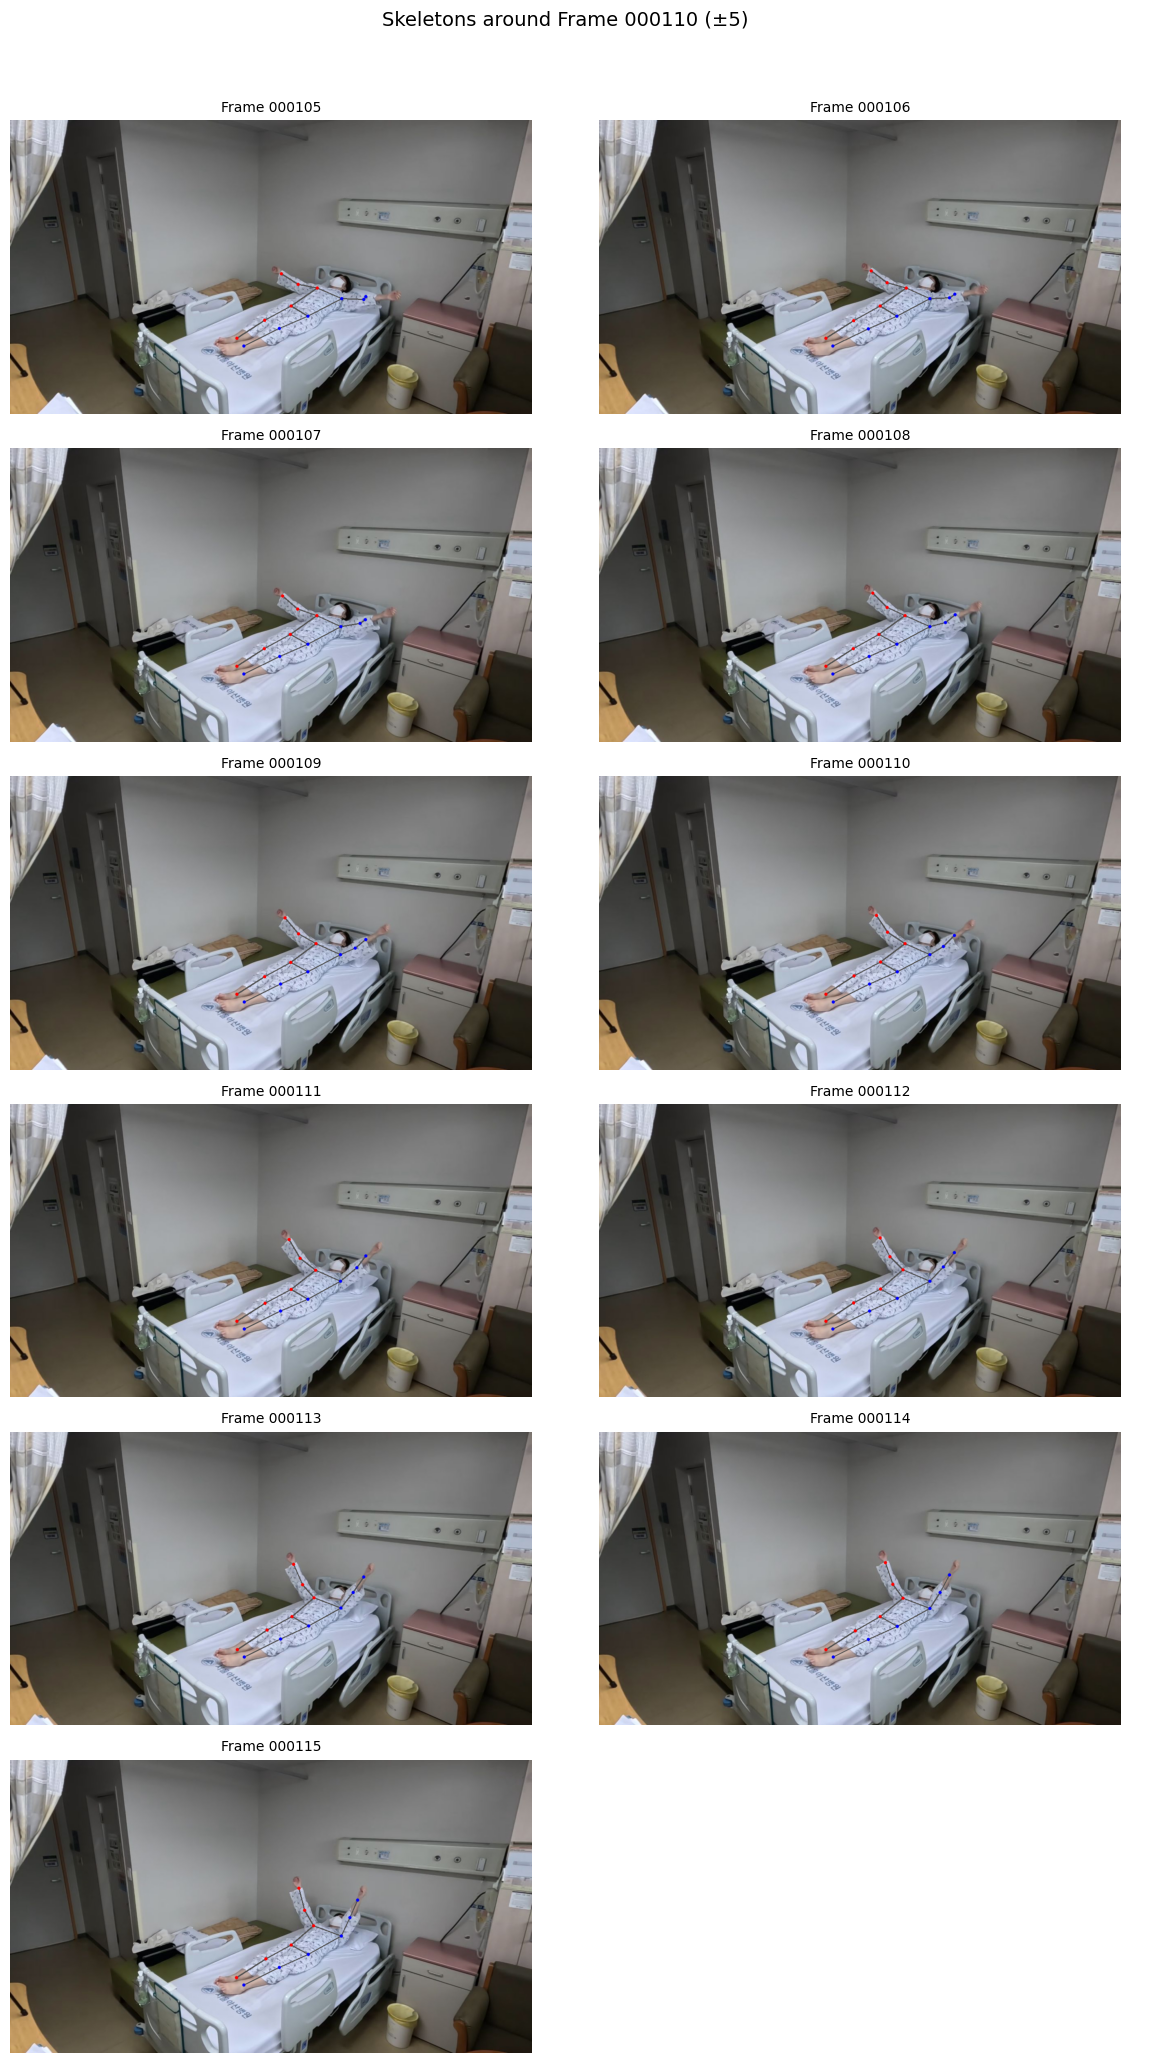

In [40]:
# 기준 프레임 100 → 앞뒤 5프레임씩 (총 11장)
visualize_frame_overlay(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    frame_idx=110,
    window=5
)


## IQR 시각화

[INFO] 총 345개 JSON 로드 중...


100% 345/345 [00:00<00:00, 1153.09it/s]


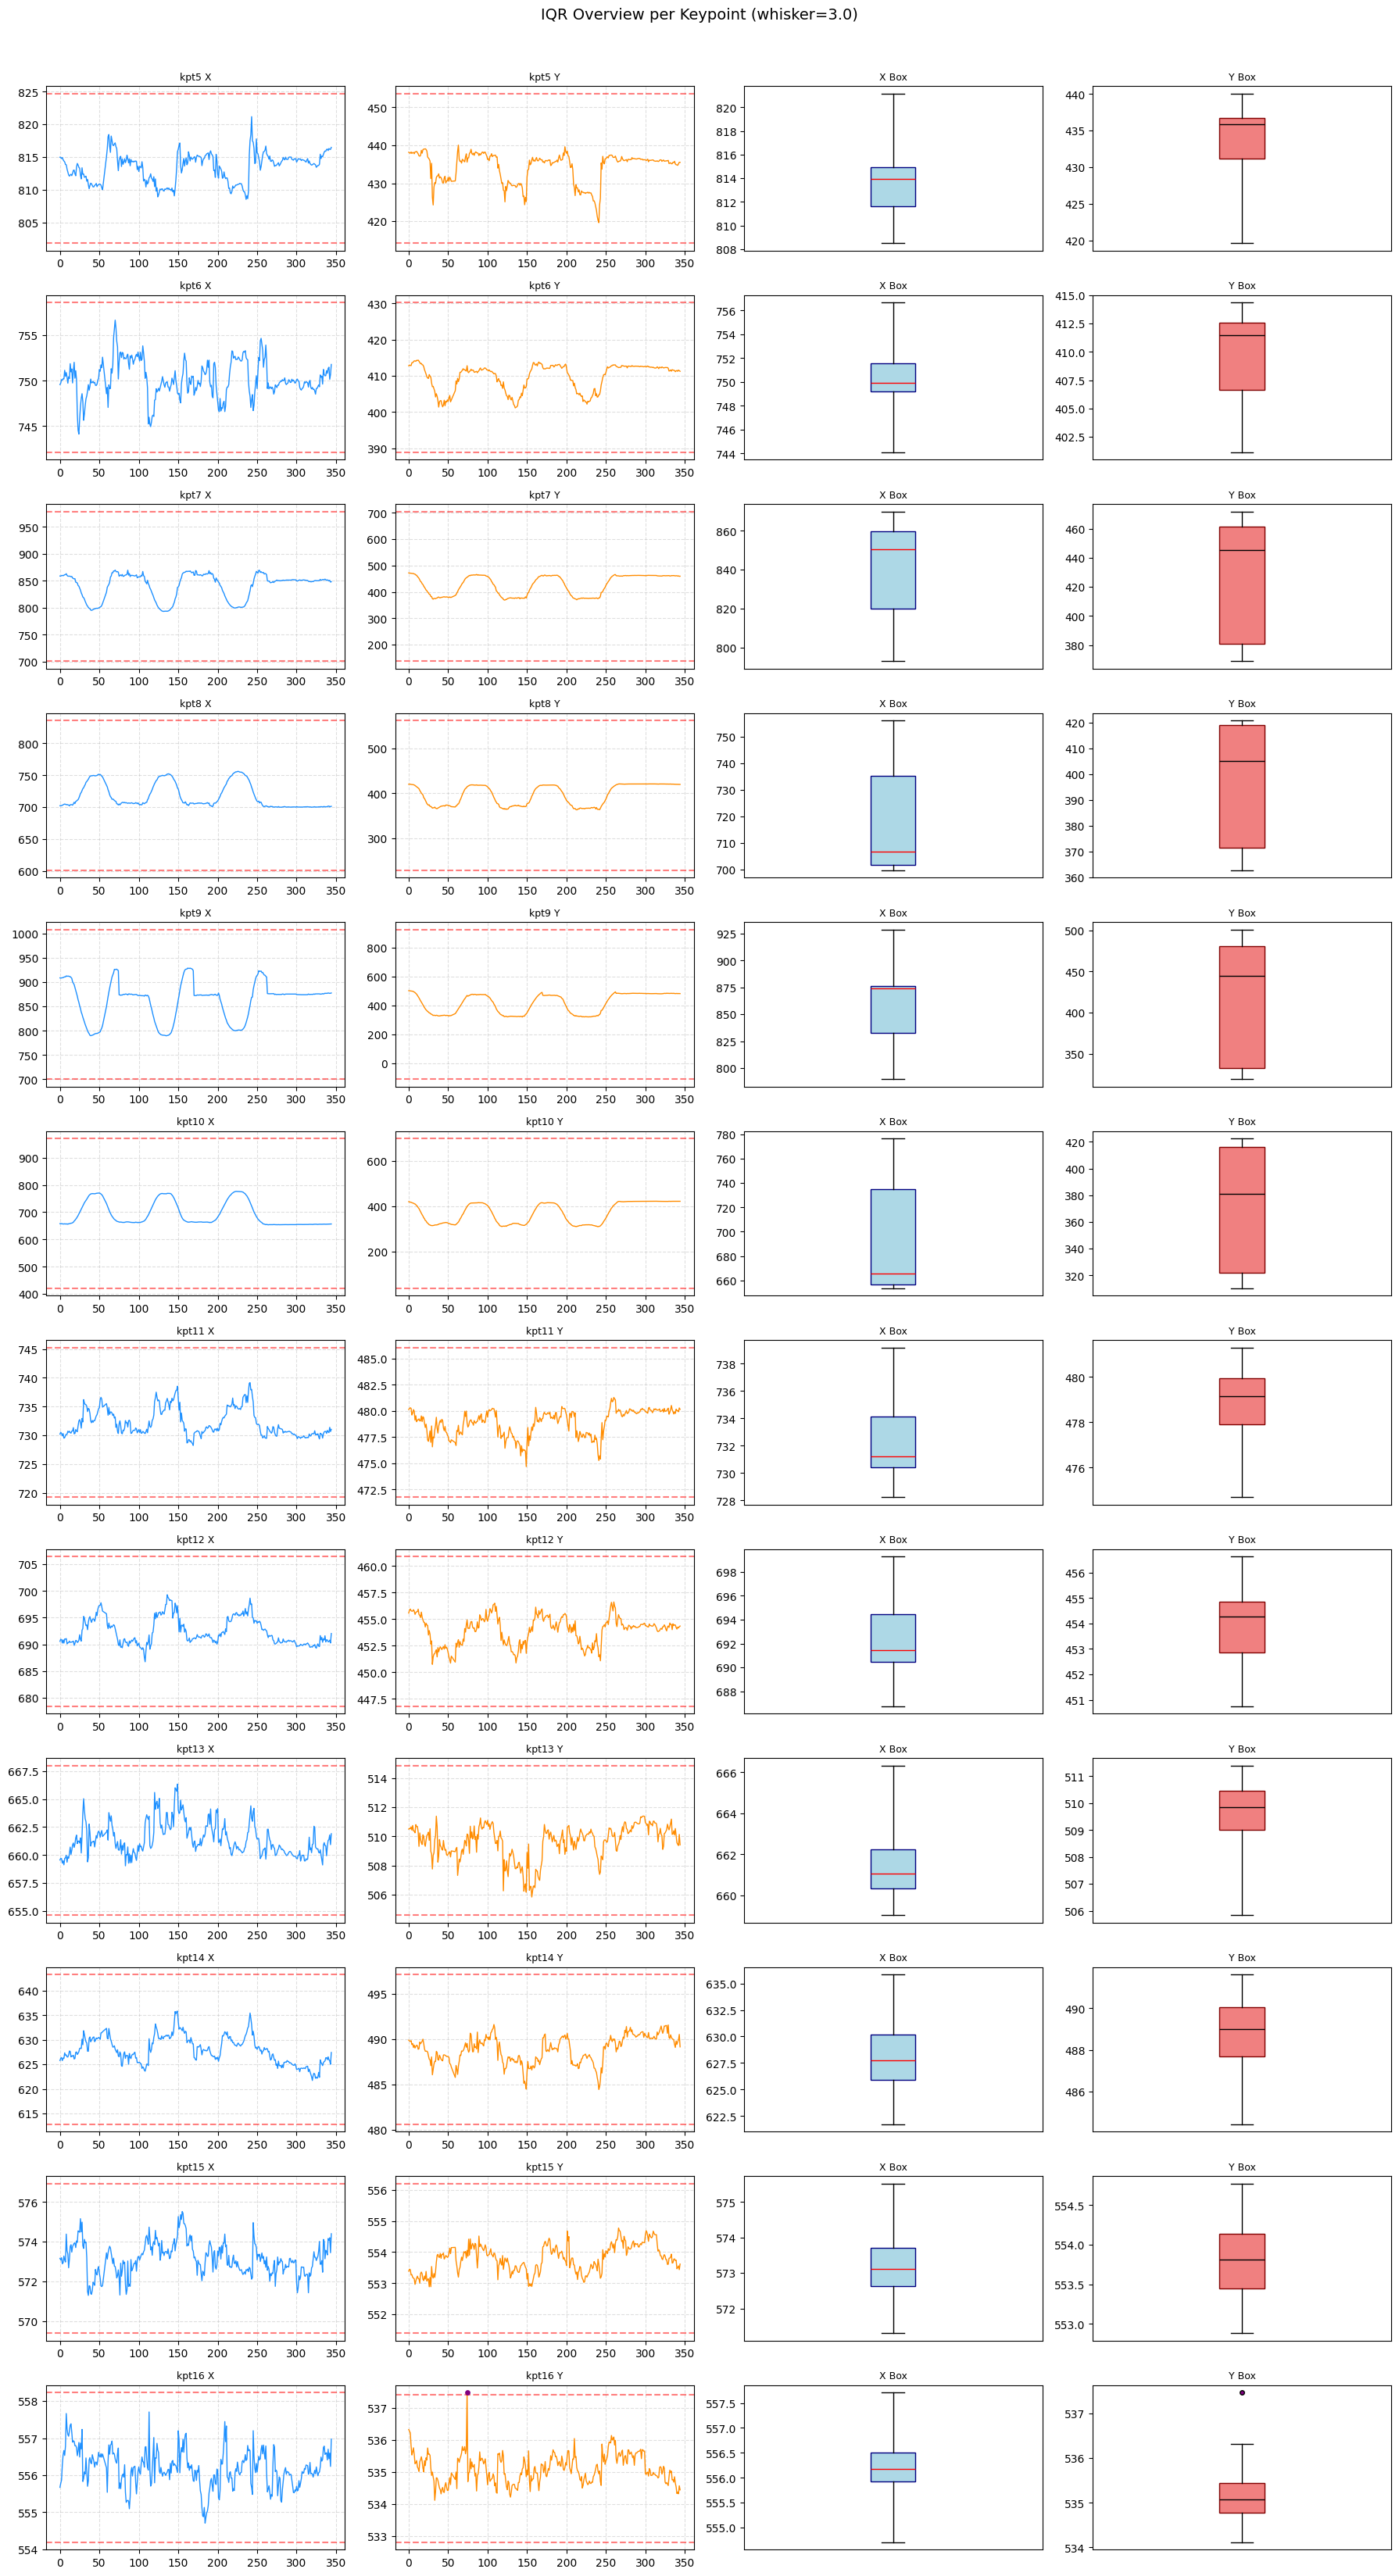

In [36]:
plot_keypoint_iqr_overview(INTERP_DIR, keypoint_range=(5, 17), whisker=3.0)

## velocity outlier 시각화

[INFO] 총 345개 JSON 로드 중...


Loading JSON: 100% 345/345 [00:00<00:00, 1634.48it/s]



[INFO] Keypoint 9
  X outliers (ΔX > z2.5): [75, 170, 245, 263]
  Y outliers (ΔY > z2.5): [111, 170, 197, 244]
  Speed outliers (|V| > z2.5): [75, 170, 244, 263]


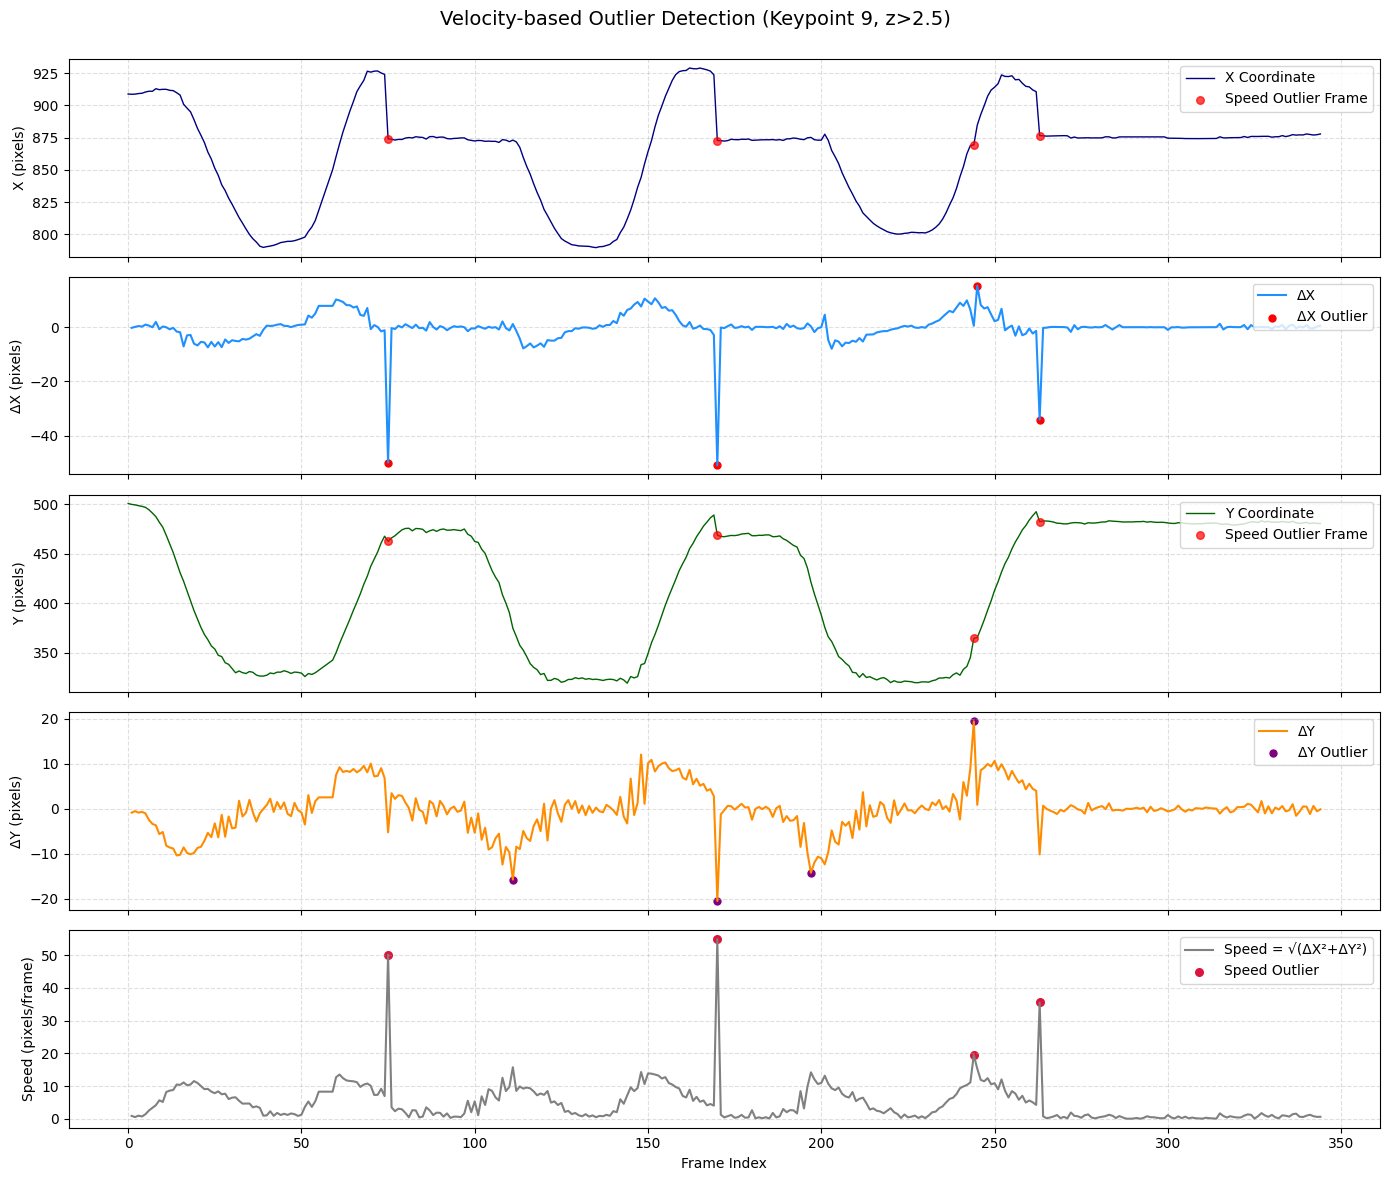

In [41]:
plot_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[9],
    z_thresh=2.5   # z-score 임계값 (2.5~3.0 추천)
)


[INFO] 총 345개 JSON 로드 중...


Loading JSON: 100% 345/345 [00:00<00:00, 6880.98it/s]


[INFO] 선형 보간을 수행한 구간:
 - 프레임 21부터 73까지 보간 완료.
 - 프레임 123부터 168까지 보간 완료.
 - 프레임 218부터 266까지 보간 완료.


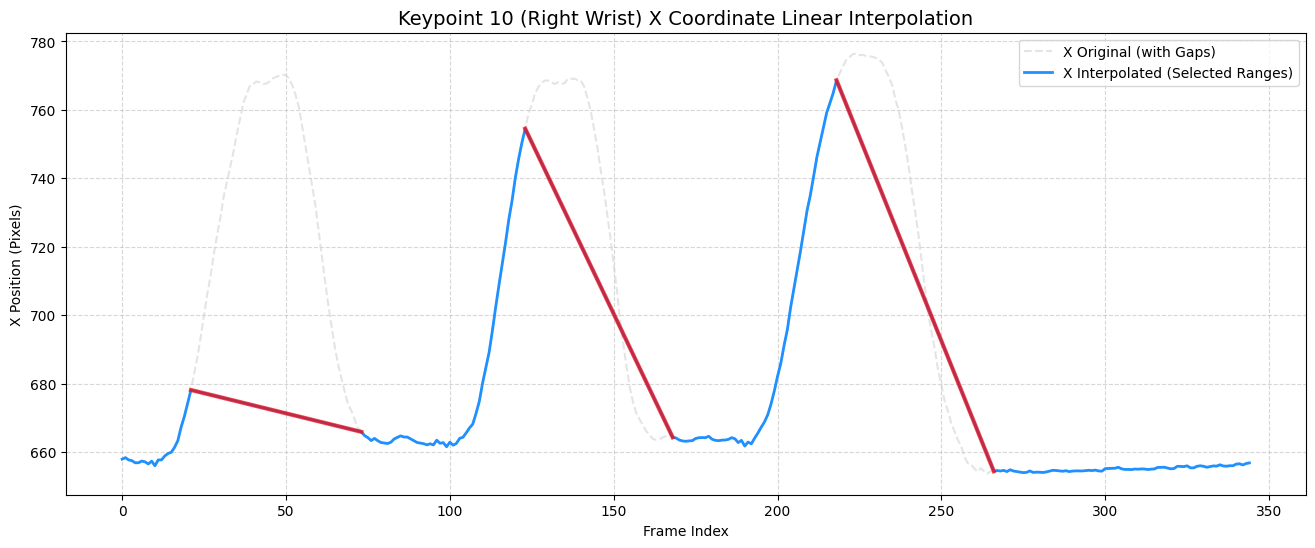


[INFO] Keypoint 10의 X 좌표를 345개 파일에 덮어쓰는 중...


Overwriting JSON: 100% 345/345 [00:00<00:00, 349.94it/s]


✅ 덮어쓰기 완료.


In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------
# 1️⃣ 데이터 로드 함수 (이전과 동일)
# -------------------------------------------------------
def load_keypoint_data(json_dir: Path, num_kps: int = 17):
    """
    JSON 파일에서 Keypoint 좌표(X, Y)만 로드하여 (Frame, KP, 2) 배열로 반환합니다.
    """
    json_files = sorted(json_dir.glob("*.json"))
    print(f"[INFO] 총 {len(json_files)}개 JSON 로드 중...")

    all_kpts = []
    
    for jfile in tqdm(json_files, desc="Loading JSON"):
        with open(jfile, "r", encoding="utf-8") as f:
            data = json.load(f)
            
        kpts = np.full((num_kps, 2), np.nan)
        
        if data.get("instance_info") and data["instance_info"]:
            instance = data["instance_info"][0]
            
            if "keypoints" in instance:
                loaded_kpts = np.array(instance["keypoints"])
                N = min(num_kps, loaded_kpts.shape[0])
                # [x, y, score] 구조일 경우에도 [x, y]만 로드
                kpts[:N, :] = loaded_kpts[:N, :2] 

        all_kpts.append(kpts)
        
    return np.stack(all_kpts) # (frame, kp, 2)

# -------------------------------------------------------
# 2️⃣ 특정 구간 선형 보간 및 시각화 함수
# -------------------------------------------------------
def interpolate_kp_x_ranges(json_dir: Path, kp_idx: int = 10, ranges: list = None):
    """
    지정된 Keypoint (기본 10번, 오른쪽 손목)의 X 좌표에서 
    주어진 프레임 구간에 대해 선형 보간을 수행하고 시각화합니다.
    
    Args:
        json_dir (Path): keypoints JSON 폴더
        kp_idx (int): 확인할 keypoint 인덱스 (기본 10: 오른쪽 손목)
        ranges (list): 보간을 수행할 [시작_프레임, 끝_프레임] 리스트.
                       예: [[21, 37], [123, 168], [218, 266]]
    """
    if ranges is None:
        ranges = [[21, 37], [123, 168], [218, 266]]

    # 1. 데이터 로드 및 X 좌표 추출
    all_kpts = load_keypoint_data(json_dir)
    frames = np.arange(len(all_kpts))
    
    if kp_idx >= all_kpts.shape[1]:
        print(f"[ERROR] Keypoint {kp_idx}는 데이터에 존재하지 않습니다.")
        return

    xs_original = all_kpts[:, kp_idx, 0]
    xs_interp = xs_original.copy()
    
    # 2. 지정된 구간에 대해 선형 보간 수행
    print("\n[INFO] 선형 보간을 수행한 구간:")
    
    for start_frame, end_frame in ranges:
        # 보간 시작 및 끝점 인덱스 확인
        start_idx = start_frame 
        end_idx = end_frame
        
        if start_idx < 0 or end_idx >= len(frames) or start_idx >= end_idx:
            print(f" - [WARN] 구간 [{start_frame}, {end_frame}]이 유효하지 않거나 데이터 범위를 벗어납니다. 스킵합니다.")
            continue
            
        # 보간 경계 프레임 (유효한 값이어야 함)
        x_start_val = xs_original[start_idx]
        x_end_val = xs_original[end_idx]
        
        if np.isnan(x_start_val) or np.isnan(x_end_val):
            print(f" - [WARN] 구간 [{start_frame}, {end_frame}]: 시작/끝 프레임 중 하나 이상이 NaN이어서 보간이 불가능합니다. 스킵합니다.")
            continue
        
        # 보간 대상 프레임 (시작+1 ~ 끝-1)
        interp_frames = frames[start_idx + 1 : end_idx]
        
        # 보간 수행
        # np.interp(보간할 x값, [시작 x, 끝 x], [시작 y, 끝 y])
        interpolated_values = np.interp(
            interp_frames,
            [start_idx, end_idx],
            [x_start_val, x_end_val]
        )
        
        # 결과 저장 (시작점과 끝점은 원본 값을 유지)
        xs_interp[start_idx + 1 : end_idx] = interpolated_values
        
        print(f" - 프레임 {start_frame}부터 {end_frame}까지 보간 완료.")

    # 3. 시각화
    plt.figure(figsize=(16, 6))
    
    # 원본 데이터 (NaN 값으로 끊어짐)
    plt.plot(frames, xs_original, color='lightgray', linestyle='--', alpha=0.6, label='X Original (with Gaps)')
    
    # 보간된 데이터
    plt.plot(frames, xs_interp, color='dodgerblue', linewidth=2, label='X Interpolated (Selected Ranges)')
    
    # 보간 구간 강조 표시
    for start_frame, end_frame in ranges:
        plt.plot(frames[start_frame:end_frame+1], xs_interp[start_frame:end_frame+1], 
                 color='red', linewidth=3, alpha=0.7)
    
    plt.title(f"Keypoint {kp_idx} (Right Wrist) X Coordinate Linear Interpolation", fontsize=14)
    plt.xlabel("Frame Index")
    plt.ylabel("X Position (Pixels)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 보간된 데이터를 포함한 Keypoint 배열을 저장해야 한다면, 
    # xs_interp를 all_kpts 배열에 다시 넣어 리턴하거나, 
    # 별도의 파일로 저장하는 로직을 추가할 수 있습니다.
    
    return xs_interp
# -------------------------------------------------------
# 3️⃣ 보간된 데이터를 JSON 파일에 덮어쓰는 함수 (새로 추가)
# -------------------------------------------------------
def overwrite_interp_to_json(
    json_dir: Path, 
    kp_idx: int, 
    xs_interp: np.ndarray
):
    """
    보간된 X 좌표 데이터를 해당 프레임의 JSON 파일에 덮어씁니다.

    Args:
        json_dir (Path): keypoints JSON 폴더 경로
        kp_idx (int): 보간을 수행한 keypoint 인덱스 (여기서는 10)
        xs_interp (np.ndarray): 보간된 X 좌표 배열 (프레임 수 길이)
    """
    json_files = sorted(json_dir.glob("*.json"))
    
    if len(json_files) != len(xs_interp):
        print(f"[ERROR] JSON 파일 수 ({len(json_files)})와 보간된 데이터 길이 ({len(xs_interp)})가 일치하지 않아 덮어쓰기를 취소합니다.")
        return

    print(f"\n[INFO] Keypoint {kp_idx}의 X 좌표를 {len(json_files)}개 파일에 덮어쓰는 중...")

    for i, jfile in enumerate(tqdm(json_files, desc="Overwriting JSON")):
        try:
            # 1. 원본 파일 로드
            with open(jfile, "r", encoding="utf-8") as f:
                data = json.load(f)
            
            # 2. 보간된 X 값 추출
            new_x_val = float(xs_interp[i])
            
            # 3. 데이터 덮어쓰기
            if data.get("instance_info") and data["instance_info"]:
                instance = data["instance_info"][0]
                
                # 'keypoints' 필드 확인 (X, Y 좌표 리스트)
                if "keypoints" in instance and len(instance["keypoints"]) > kp_idx:
                    # 해당 키포인트의 X 좌표(인덱스 0)를 덮어씀
                    instance["keypoints"][kp_idx][0] = new_x_val
                
                # 'keypoints' 필드가 없거나 키포인트 수가 부족한 경우 (극히 드물지만 예외 처리)
                else:
                    # 경고 메시지 출력
                    print(f" - [WARN] Frame {i} ({jfile.name}): 'keypoints' 필드 구조가 예상과 다르거나 KP {kp_idx}가 누락되었습니다. 스킵합니다.")
                    continue
            else:
                # instance_info가 없는 파일은 덮어쓰기 대상이 아님
                continue

            # 4. JSON 파일 저장
            # 덮어쓰기 전에 백업을 고려해야 하지만, 여기서는 요청대로 직접 덮어씁니다.
            with open(jfile, "w", encoding="utf-8") as f:
                json.dump(data, f, indent=4) # 가독성을 위해 indent=4 사용 (필요시 제거 가능)

        except Exception as e:
            print(f" - [ERROR] Frame {i} ({jfile.name}) 처리 중 오류 발생: {e}. 스킵합니다.")
            
    print("\n✅ 덮어쓰기 완료.")
# -------------------------------------------------------
# 함수 실행 (사용자 지정 구간)
# -------------------------------------------------------
# INTERP_DIR 변수가 정의되었다고 가정
interpolated_x = interpolate_kp_x_ranges(
    json_dir=INTERP_DIR, 
    kp_idx=10, 
    ranges=[[21, 73], [123, 168], [218, 266]]
)

# 2. 보간된 데이터가 성공적으로 생성되었는지 확인 후 덮어쓰기 실행
if interpolated_x is not None:
    overwrite_interp_to_json(
        json_dir=INTERP_DIR, 
        kp_idx=10, 
        xs_interp=interpolated_x
    )

## Confidence score 확인

[INFO] 총 344개 JSON 로드 중...


Loading JSON: 100% 344/344 [00:00<00:00, 6535.85it/s]


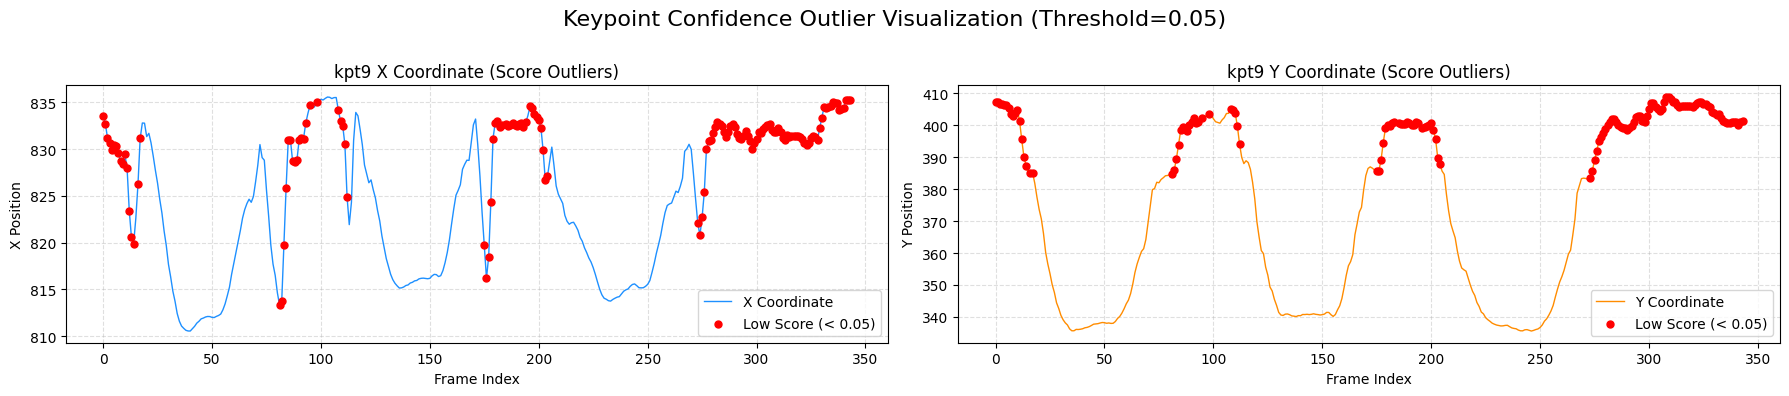

In [ ]:

# ❌ 수정 필요: 마지막 콜론을 제거합니다.
plot_confidence_outliers(
    json_dir = INTERP_DIR,
    target_kps = [9], 
    threshold = 0.05
)

## 좌표 Threshold outlier 탐지 함수

[INFO] 총 344개 JSON 로드 중...


Loading JSON: 100% 344/344 [00:00<00:00, 2384.29it/s]


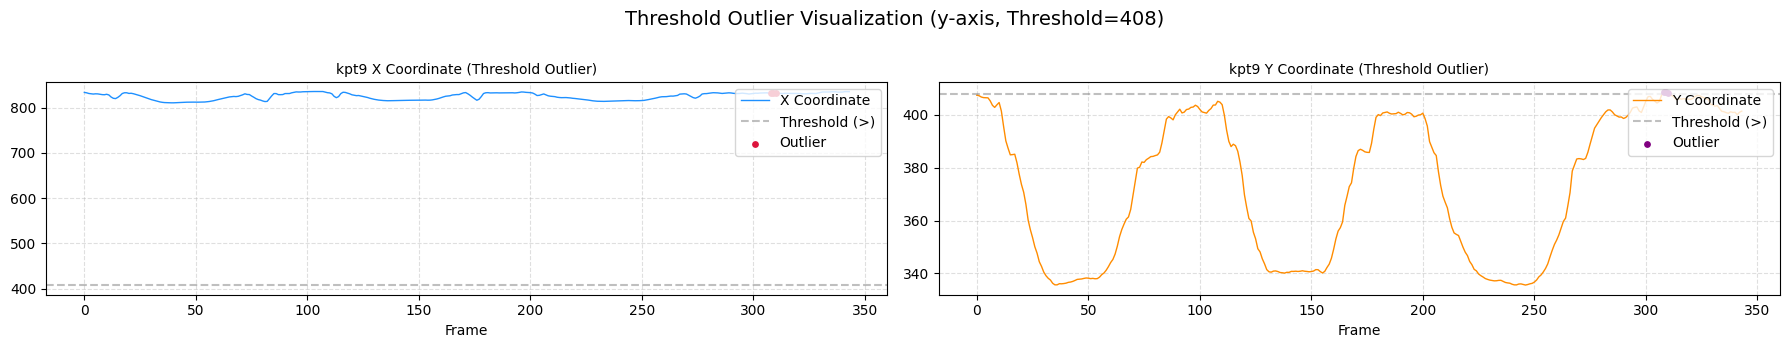

[308, 309, 310]


In [ ]:
# 예시 호출
outlier_frames_list = plot_threshold_outlier_kps(
    json_dir=INTERP_DIR,
    target_kps=[9], 
    threshold=408, 
    axis='y',
    comparison='gt'
)

# 아웃라이어 프레임 목록 확인
print(outlier_frames_list)

# 보간 및 변경

## 대상(환자) 추출

In [ ]:
overwrite_json_with_tracked_patient(INTERP_DIR)


## 결측치 보간

In [ ]:
interpolate_missing_keypoints(
    json_dir=INTERP_DIR,  # 결측치가 존재하는 폴더
    save_dir=None          # None → 원본 덮어쓰기
)


## 특정 frame 선형 보간

In [47]:
manual_linear_interpolate_frames(
    json_dir=INTERP_DIR,
    target_frames= [0, 1, 18, 71, 73, 115, 116, 117, 118, 119, 166, 169, 170, 207, 271, 295, 296, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343],   # 연속 & 비연속 혼합
    target_kps=[7]
)


[INFO] 총 49개 target frame → 연속 구간 단위 보간 시작
✅ Frames 0~1: 첫 프레임 구간 → 다음 정상 프레임(2) 값 복사 완료 ([7])
✅ Frame 18: 단일 프레임 보간 완료 ([7])
✅ Frame 71: 단일 프레임 보간 완료 ([7])
✅ Frame 73: 단일 프레임 보간 완료 ([7])
✅ Frames 115~119: 연속 구간 보간 완료 ([7])
✅ Frame 166: 단일 프레임 보간 완료 ([7])
✅ Frames 169~170: 연속 구간 보간 완료 ([7])
✅ Frame 207: 단일 프레임 보간 완료 ([7])
✅ Frame 271: 단일 프레임 보간 완료 ([7])
✅ Frames 295~296: 연속 구간 보간 완료 ([7])
✅ Frames 312~343: 마지막 프레임 구간 → 이전 정상 프레임(311) 값 복사 완료 ([7])
🎯 모든 지정 프레임 보간 완료 ✅


## keypoints 고정


In [36]:
# 예: 315 프레임의 8번, 10번 keypoints를 전체 프레임에 고정
fix_keypoints_across_frames(
    json_dir=INTERP_DIR,
    ref_frame=152,
    target_kps=[8,10]
)

[INFO] 기준 프레임 152의 [8, 10]번 keypoints 좌표 고정값 → {8: array([706.18869429, 419.63735185]), 10: array([645.07340425, 454.94108089])}


Fixing keypoints:   0% 0/536 [00:00<?, ?it/s]

Fixing keypoints: 100% 536/536 [00:01<00:00, 304.68it/s]

✅ [8, 10]번 keypoints를 프레임 152 기준으로 전체 고정 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__one_leg_bridge_dynamic


## IQR Outlier 보간

In [35]:
interpolate_outliers(
    json_dir=INTERP_DIR,
    target_kps=[5,6,7,8,9,10,11,12,13,14,15,16],
    whisker=3.0,
    axis='both' #x,y,both
)


[INFO] 총 345개 JSON 로드 중...
[INFO] kpt5: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt6: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt7: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt8: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt9: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt10: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt11: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt12: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt13: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))]
[INFO] kpt14: 4개 Outlier → both-축 기준 연속 구간 보간 중...
    → 보간 완료 구간: [(np.int64(55), np.int64(58))

Saving interpolated JSON: 100% 345/345 [00:01<00:00, 336.45it/s]

✅ Outlier 보간 완료 (both-축, keypoints=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], whisker=3.0) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__pec_dec_fly


## velocity 보간

In [54]:
interpolate_velocity_outliers(
    json_dir=INTERP_DIR,
    target_kps=[8],
    z_thresh=3.0
)


[INFO] 총 344개 JSON 로드 중...
[INFO] kpt8: 7개 Outlier → 연속 구간 단위 보간 중...
    → 보간 구간 26~26 (1프레임) 완료
    → 보간 구간 83~83 (1프레임) 완료
    → 보간 구간 116~116 (1프레임) 완료
    → 보간 구간 127~127 (1프레임) 완료
    → 보간 구간 176~176 (1프레임) 완료
    → 보간 구간 216~217 (2프레임) 완료


Saving interpolated JSON:   0% 0/344 [00:00<?, ?it/s]

Saving interpolated JSON: 100% 344/344 [00:01<00:00, 322.61it/s]

✅ 연속 outlier 보간 완료 (keypoints=[8], z_thresh=3.0) → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__overhead_triceps_extension


## smoothing 적용

In [30]:
smooth_keypoints(
    json_dir=INTERP_DIR,
    # target_kps=[5,6,7,8,9,10,11,12,13,14,15,16],  # 어깨~발목 전체
    target_kps=[9], # 어깨~발목 전체
    window=10,        # 🔹 노이즈가 적을 땐 작은 윈도우 (3~5)
    method="moving"  # 🔹 단순 이동평균
)


[INFO] 총 345개 JSON 로드 → smoothing keypoints: [9]


Saving smoothed JSON: 100% 345/345 [00:01<00:00, 232.16it/s]

✅ Smoothing 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/4_INTERP_DATA/AI_dataset/N02/N02_Ward/diagonal__pec_dec_fly


# 영상 생성

In [29]:
import sys
sys.path.append("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/ASAN_01_Repeatition_Counter")

from functions.render_skeleton_video import render_skeleton_video
render_skeleton_video(
    frame_dir=FRAME_DIR,
    json_dir=INTERP_DIR,
    out_mp4=VIDEO_DIR,
    fps=30,
    model_type="coco17",
    
)

diagonal__pec_dec_fly: 100% 345/345 [00:05<00:00, 63.43frame/s]

✅ Skeleton overlay 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/AI_dataset/N02/N02_Ward/diagonal__pec_dec_fly.mp4


# CSV is_train 업데이트

In [ ]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------
# TARGET_ROW의 is_train 값 변경
# -------------------------------------------------------
meta.loc[TARGET_ROW, 'is_train'] = True  # True로 설정
print(f"[INFO] {TARGET_ROW}행의 is_train 값을 True로 변경했습니다.")

# -------------------------------------------------------
# CSV 저장
# -------------------------------------------------------
meta.to_csv(CSV_PATH, index=False)  # 덮어쓰기 저장
print(meta.loc[TARGET_ROW,'video_path'])
print(f"✅ 변경사항을 저장했습니다: {CSV_PATH}")
